# SCF optimization

Let us implement the presented Hartree–Fock SCF procedure. We will use the water molecule as an illustration.

In [1]:
import numpy as np
import scipy
import veloxchem as vlx

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 6.


## Reference calculation

### SCF energy

Let us first perform an reference calculation using the restricted closed-shell SCF driver in VeloxChem named `ScfRestrictedDriver`.

In [2]:
h2o_xyz = """3

O    0.000000000000        0.000000000000        0.000000000000
H    0.000000000000        0.740848095288        0.582094932012
H    0.000000000000       -0.740848095288        0.582094932012
"""

molecule = vlx.Molecule.read_xyz_string(h2o_xyz)
basis = vlx.MolecularBasis.read(molecule, "cc-pVDZ", ostream=None)

In [ ]:
molecule.show()

In [ ]:
scf_drv = vlx.ScfRestrictedDriver()
scf_drv.ostream.mute()
scf_results = scf_drv.compute(molecule, basis)

In [4]:
print(f"Final HF energy: {scf_drv.get_scf_energy() : 12.8f} Hartree")

Final HF energy: -76.02698419 Hartree


### Some system parameters

In [5]:
norb = basis.get_dimensions_of_basis()
nocc = molecule.number_of_alpha_electrons()
V_nuc = molecule.nuclear_repulsion_energy()

print("Number of contracted basis functions:", norb)
print("Number of doubly occupied molecular orbitals:", nocc)
print(f"Nuclear repulsion energy (in a.u.): {V_nuc : 14.12f}")

Number of contracted basis functions: 24
Number of doubly occupied molecular orbitals: 5
Nuclear repulsion energy (in a.u.):  9.343638157670


## Getting integrals in AO basis

In [6]:
# overlap matrix
S = vlx.compute_overlap_integrals(molecule, basis)

# one-electron Hamiltonian
T = vlx.compute_kinetic_energy_integrals(molecule, basis)

V = vlx.compute_nuclear_potential_integrals(molecule, basis)

h = T + V

# two-electron Hamiltonian
fock_drv = vlx.FockDriver()
g = fock_drv.compute_eri(molecule, basis)

## Convergence measure

As a measure of convergence, we adopt the norm of the following matrix in AO basis

$$
\mathbf{e} = 
\mathbf{F D S} -
\mathbf{S D F}
$$

It is convenient to scatter the elements of this matrix into the format of a vector and which we refer to as the *error vector*. During the course of the SCF iterations, we form a sequence of error vectors, $\mathbf{e}_i$.

The choice of convergence metric may at first appear unintuitive but becomes less so in the MO basis

$$
\mathbf{e}^\mathrm{MO} = 
\mathbf{C}^\dagger \mathbf{e} \, \mathbf{C} =
\begin{bmatrix}
0 & -F_\mathrm{ov} \\
F_\mathrm{vo} & 0 \\
\end{bmatrix}
$$

where it is seen to correspond to vanishing occupied—virtual blocks in the Fock matrix.

## SCF iterations

We form an initial guess for the density based on the core Hamiltonian. 

In [7]:
# initial guess from core Hamiltonian
epsilon, C = scipy.linalg.eigh(h, S)

 Next, we perform SCF iterations until convergence (or the maximum number of iterations) is reached.

In [8]:
max_iter = 50
conv_thresh = 1e-6

error_RH = []

In [9]:
print("iter      SCF energy    Error norm")

for iter in range(max_iter):

    D = np.einsum("ik,jk->ij", C[:, :nocc], C[:, :nocc])

    J = np.einsum("ijkl,kl->ij", g, D)
    K = np.einsum("ilkj,kl->ij", g, D)
    F = h + 2 * J - K

    E = np.einsum("ij,ij->", h + F, D) + V_nuc

    # compute convergence metric
    e_mat = np.linalg.multi_dot([F, D, S]) - np.linalg.multi_dot([S, D, F])
    e_vec = e_mat.reshape(-1)
    error = np.linalg.norm(e_vec)

    print(f"{iter:>2d}  {E:16.8f}  {error:10.2e}")
    error_RH.append(error)

    if error < conv_thresh:
        print("SCF iterations converged!")
        break

    epsilon, C = scipy.linalg.eigh(F, S)

iter      SCF energy    Error norm
 0      -68.84975229    3.09e+00
 1      -69.95937641    2.88e+00
 2      -73.34743276    2.83e+00
 3      -73.46688910    2.23e+00
 4      -74.74058933    2.18e+00
 5      -75.55859127    1.41e+00
 6      -75.86908635    8.26e-01
 7      -75.97444165    4.82e-01
 8      -76.00992921    2.74e-01
 9      -76.02143957    1.57e-01
10      -76.02519173    8.89e-02
11      -76.02640379    5.06e-02
12      -76.02679653    2.88e-02
13      -76.02692347    1.64e-02
14      -76.02696455    9.31e-03
15      -76.02697784    5.30e-03
16      -76.02698213    3.01e-03
17      -76.02698352    1.71e-03
18      -76.02698397    9.74e-04
19      -76.02698412    5.54e-04
20      -76.02698416    3.15e-04
21      -76.02698418    1.79e-04
22      -76.02698418    1.02e-04
23      -76.02698419    5.80e-05
24      -76.02698419    3.30e-05
25      -76.02698419    1.88e-05
26      -76.02698419    1.07e-05
27      -76.02698419    6.07e-06
28      -76.02698419    3.45e-06
29      

We note the final energy is in perfect agreement with that of the reference calculation.

# Convergence acceleration

## Direct inversion iterative subspace

The Rothaan–Hall scheme suffer from poor numerical convergence and in practice some version of convergence acceleration is adopted. In the method of direct inversion of the iterative subspace (DIIS) {cite}`Pulay1980, Pulay1982, Sellers1993` information is used from not only the present but also previous iterations to form an *averaged* effective one-electron Hamiltonian, or Fock matrix, according to

$$
\mathbf{F}_n^\mathrm{DIIS} = \sum_{i=1}^n w_i \mathbf{F}_i
$$

where $\mathbf{F}_i$ is the Fock matrix generated in SCF iteration $i$, $n$ is present iteration, and the weights, $w_i$, are to be determined. To guarantee that the one-electron Hamiltonian is preserved in the effective Fock operator,  we impose the condition

$$
\sum_{i=1}^n w_i = 1
$$

Under the assumption of a strict linearity between Fock matrices and error vectors, the error vector of the averaged Fock matrix would equal

$$
\mathbf{e}_n^\mathrm{DIIS} = \sum_{i=1}^n w_i \mathbf{e}_i
$$

As the molecular orbitals change from one iteration to the next, this is not strictly the case but it is a good approximation. We can then determine the weights by minimizing the squared norm of this error vector under the imposed constraint. The squared norm becomes equal to

$$
\| \mathbf{e}_n^\mathrm{DIIS} \|^2 =
\sum_{i,j=1}^n w_i B_{ij} w_j ; \quad
B_{ij} = \langle \mathbf{e}_i | \mathbf{e}_j \rangle
$$

and the constrained minimization is achieved by introducing a Lagrangian

$$
L =
\| \mathbf{e}_n^\mathrm{DIIS} \|^2 - 2\lambda
\Big(
\sum_{i=1}^n w_i - 1
\Big)
$$

where the factor of $-2$ multiplying the Lagrange multiplier $\lambda$ is a mere convention as to arrive at an explicit matrix equation of the form

$$
\begin{pmatrix}
B_{11} & \cdots & B_{1n} & -1 \\
\vdots & \ddots & \vdots & \vdots \\
B_{n1} & \cdots & B_{nn} & -1 \\
-1 & \cdots & -1 & 0
\end{pmatrix}
\begin{pmatrix}
w_1 \\ \vdots \\ w_n \\ \lambda
\end{pmatrix}
=
\begin{pmatrix}
0 \\ \vdots \\ 0 \\ -1
\end{pmatrix}
$$

We solve this equation for the weights, $w_i$, and then determine the averaged Fock matrix, $\mathbf{F}_n^\mathrm{DIIS}$.

In [10]:
def c1diis(F_mats, e_vecs):

    n = len(e_vecs)

    # build DIIS matrix
    B = -np.ones((n + 1, n + 1))
    B[n, n] = 0

    for i in range(n):
        for j in range(n):
            B[i, j] = np.dot(e_vecs[i], e_vecs[j])

    b = np.zeros(n + 1)
    b[n] = -1

    w = np.matmul(np.linalg.inv(B), b)

    F_diis = np.zeros((norb, norb))
    for i in range(n):
        F_diis += w[i] * F_mats[i]

    return F_diis

## SCF iterations
In principle, the only needed modification in the SCF module to implement the DIIS scheme is to replace the original Fock matrix with the weighted averaged counterpart before the determination of the new MO coefficients. But it is also required to save Fock matrices and error vectors from previous SCF iterations. In practice, this extra storage requirement does not severely hamper applications, and in particular so as an optimum stabilitity in the DIIS scheme is experienced with the use of information from a limited number (about 10) of the previous iterations.

In [11]:
e_vecs = []
F_mats = []
error_DIIS = []

# initial guess from core Hamiltonian
epsilon, C = scipy.linalg.eigh(h, S)

print("iter      SCF energy    Error norm")

for iter in range(max_iter):

    D = np.einsum("ik,jk->ij", C[:, :nocc], C[:, :nocc])

    J = np.einsum("ijkl,kl->ij", g, D)
    K = np.einsum("ilkj,kl->ij", g, D)
    F = h + 2 * J - K
    F_mats.append(F)

    E = np.einsum("ij,ij->", h + F, D) + V_nuc

    # compute convergence metric
    e_mat = np.linalg.multi_dot([F, D, S]) - np.linalg.multi_dot([S, D, F])
    e_vecs.append(e_mat.reshape(-1))
    error = np.linalg.norm(e_vecs[-1])

    print(f"{iter:>2d}  {E:16.8f}  {error:10.2e}")
    error_DIIS.append(error)

    if error < conv_thresh:
        print("SCF iterations converged!")
        break

    F = c1diis(F_mats, e_vecs)
    epsilon, C = scipy.linalg.eigh(F, S)

iter      SCF energy    Error norm
 0      -68.84975229    3.09e+00
 1      -69.95937641    2.88e+00
 2      -75.88501761    8.37e-01
 3      -75.97016719    5.18e-01
 4      -76.01483442    2.34e-01
 5      -76.02676704    3.29e-02
 6      -76.02698021    3.32e-03
 7      -76.02698392    8.01e-04
 8      -76.02698418    2.04e-04
 9      -76.02698419    6.97e-05
10      -76.02698419    2.06e-06
11      -76.02698419    5.43e-07
SCF iterations converged!


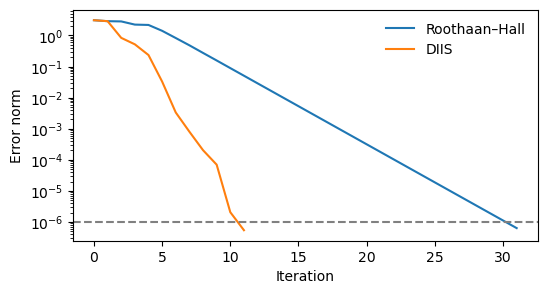

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))

plt.plot(error_RH, label="Roothaan–Hall")
plt.plot(error_DIIS, label="DIIS")

plt.yscale("log")

plt.axhline(y=conv_thresh, linestyle="--", color="grey")
plt.legend(frameon=False)
plt.xlabel("Iteration")
plt.ylabel(r"Error norm")

plt.show()